# Model Traning
Basic function and import libraries are written in functions.py file.

First run the python file by %run functions.py

In [1]:
# %load functions.py


# In[2]:


get_ipython().magic(u'matplotlib inline')
import numpy as np
import pandas as pd
import re, sys, os, csv,time
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.pipeline import Pipeline
# feature extraction and slection
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# Classifiers
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,roc_auc_score
try:
   import cPickle as pickle
except:
   import pickle

fileName_label='labelEncoder.pkl'
encoder=pickle.load(open(fileName_label,'rb'))
labels=['BILL','POLICY CHANGE','CANCELLATION NOTICE','BINDER','DELETION OF INTEREST','REINSTATEMENT NOTICE','DECLARATION','CHANGE ENDORSEMENT','RETURNED CHECK','EXPIRATION NOTICE','NON-RENEWAL NOTICE','BILL BINDER','INTENT TO CANCEL NOTICE','APPLICATION']
labels_ID=encoder.transform(labels)

def getDataSet(test_size):
    # read data from csv file
    dataset = pd.read_csv('data/shuffled-full-set-hashed.csv',header=None,sep=',',dtype=np.object_)
    dataset.columns=['Labels','Values']
    dataset=pd.DataFrame(dataset)
    print "Original Dataset Shape: ", dataset.shape
    dataset=dataset[pd.notnull(dataset)]
    print "Dataset (without null) Shape: ", dataset.shape
    dataset=dataset.drop_duplicates()
    print "Dataset (without duplicated rows) Shape: ", dataset.shape
    X=dataset['Values']
    X=[str(i) for i in X]
    Y=encoder.transform(dataset['Labels'])
    # create training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    return X_train, X_test, Y_train, Y_test

## Get Data

In [2]:
# get training and test data sets by function getDataSet(test_size)
test_size=0.1 # test size is 10% of the total dataset
X_train, X_test, Y_train, Y_test = getDataSet(test_size)

Original Dataset Shape:  (62204, 2)
Dataset (without null) Shape:  (62204, 2)
Dataset (without duplicated rows) Shape:  (60548, 2)


### Classifier Training

Two functions:

trainModel(methodName,model) is a function to train a classifier: methodName is used to name saved files, model is classification model.


In [3]:
def trainModels(methodNames,classifiers):
    time_train={}
    time_test={}
    F1={}
    for i in range(len(methodNames)):
        F1[i],time_train[i],time_test[i]=trainModel(methodNames[i],classifiers[i])
    return F1,time_train,time_test

def trainModel(methodName,classifier):
    # record training time if already trained then return 0
    time_train=0
    filename='G:\\Models\\test_'+ methodName +'.pkl'
    if os.path.isfile(filename):
        model=pickle.load(open(filename,'rb'))   # load trained model
    else:
        start_train=time.clock()
        cvt=CountVectorizer(min_df=3,ngram_range=(1, 2))
        tft=TfidfTransformer(sublinear_tf=True)
        model= Pipeline([('vect', cvt),
                         ('tfidf', tft),
                         (methodName,classifier),])
        model.fit(X_train,Y_train)               # get trained model
        time_train=time.clock()- start_train
        print "------Tranining Time-----", str(time_train)
        pickle.dump(model, open(filename,'wb'))  # save model using Pickle
    # run test
    start_test=time.clock()
    Y_pred=model.predict(X_test)                 # predict
    time_test=time.clock()- start_test
    print "------Test Time-----", str(time_test)
    Accuracy = accuracy_score(Y_test,Y_pred)
    F1={}
    F1[0] = f1_score(Y_test,Y_pred,average='micro')
    F1[1] = f1_score(Y_test,Y_pred,average='weighted')
    print '------Accuray: ',Accuracy,'; F1 (micro): ',F1[0], '; F1 (weighted): ',F1[1]
    cm=confusion_matrix(Y_test,Y_pred,labels=labels_ID)
    plotConfusionMatrix(methodName,cm)
    return F1,time_train,time_test

# plot confusion matrix
def plotConfusionMatrix(methodName,cm):
    # normalize the confusion matrix
    cm_norm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    cm_norm=np.round(cm_norm,3)
    cm_plot=pd.DataFrame(cm_norm,labels,range(14))
    # plot confusion matrix
    fig=plt.figure(figsize=(14,10))
    sn.set(font_scale=1.4)   # for label size
    sn.heatmap(cm_plot,annot=True,annot_kws={"size":16},cmap=plt.cm.Blues) #font size
    plt.title(methodName + ' Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

------Test Time----- 4.52700002788
------Accuray:  0.814203137903 ; F1 (micro):  0.814203137903 ; F1 (weighted):  0.808128121562


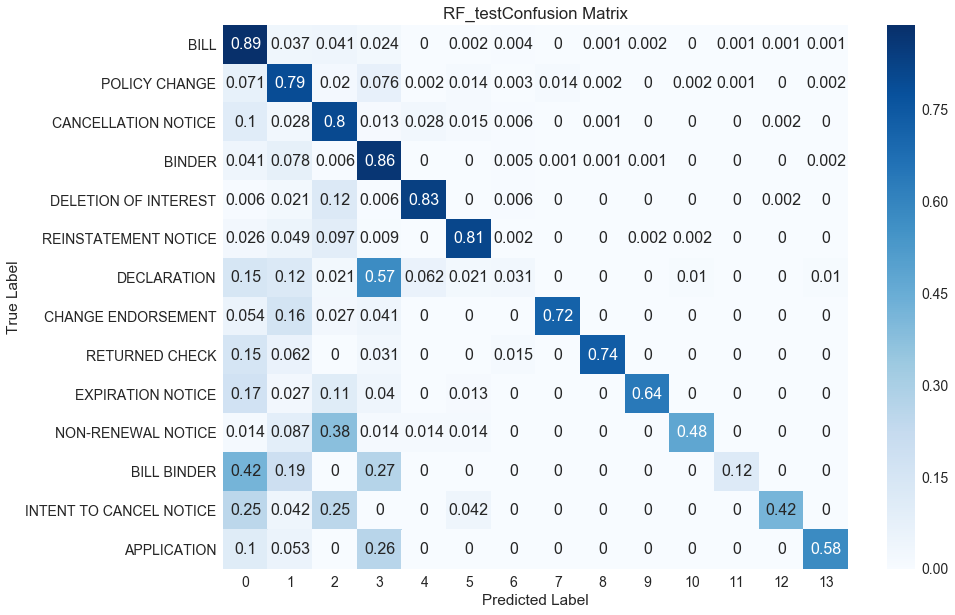

------Test Time----- 4.57078113542
------Accuray:  0.854170107349 ; F1 (micro):  0.854170107349 ; F1 (weighted):  0.855728050332


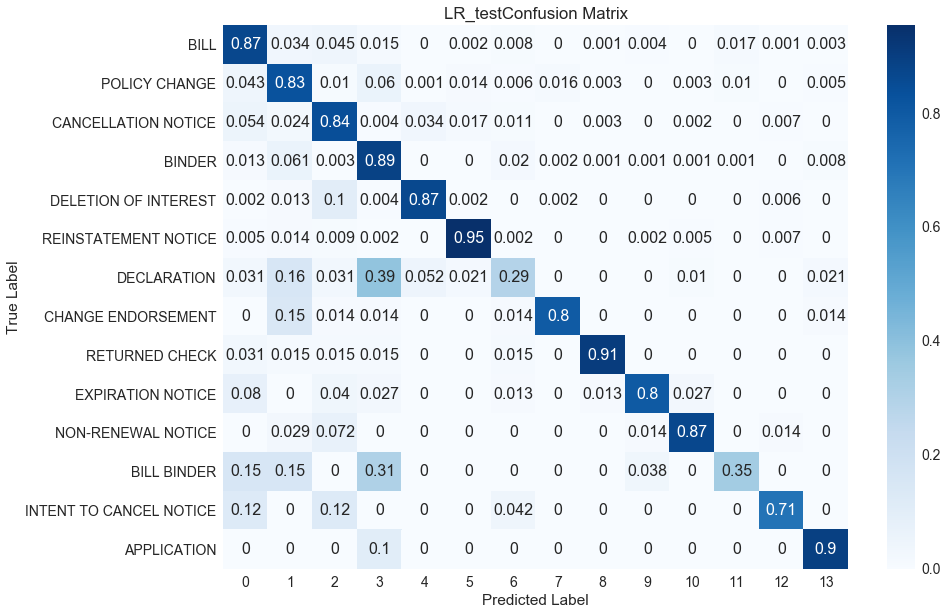

------Test Time----- 5.7126065173
------Accuray:  0.811890999174 ; F1 (micro):  0.811890999174 ; F1 (weighted):  0.812791901527


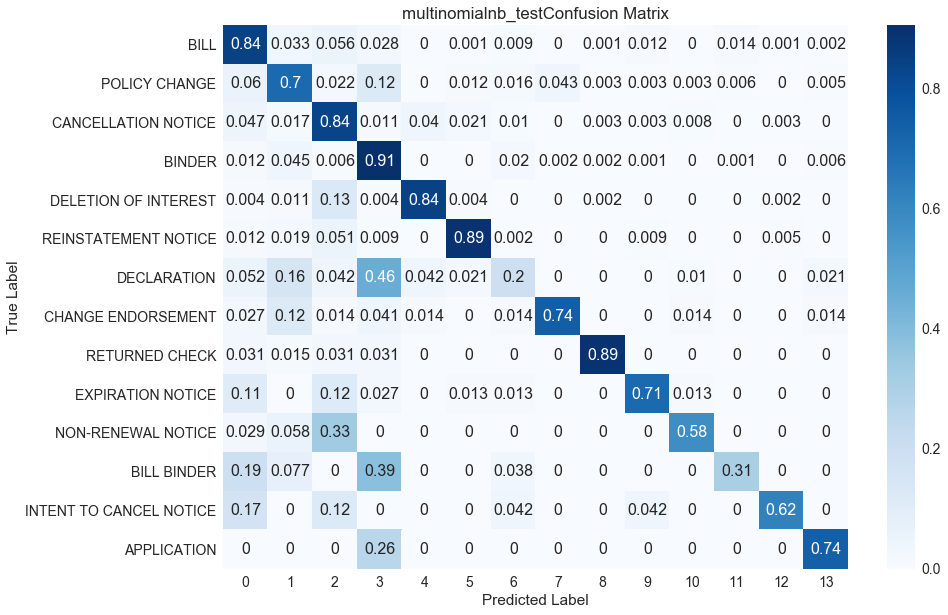

------Test Time----- 517.444151056
------Accuray:  0.864244426094 ; F1 (micro):  0.864244426094 ; F1 (weighted):  0.864401280834


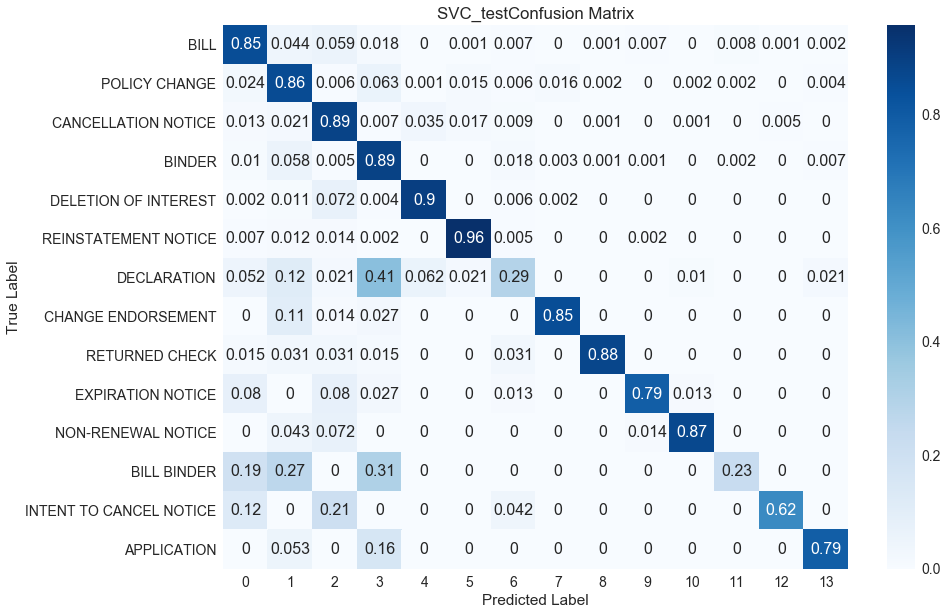

In [5]:
#train and test classifiers
from sklearn.svm import SVC
methodNames=['RF_test','LR_test','multinomialnb_test','SVC_test']
clfs=[RandomForestClassifier(class_weight='balanced'),
     LogisticRegression(class_weight='balanced',max_iter=1000),
     MultinomialNB(alpha=0.01),
     SVC(kernel='linear',class_weight='balanced')]
results=trainModels(methodNames,clfs)
fileName='ClfF1Results.pkl'
pickle.dump(results, open(fileName,'wb'))

In [6]:
# print results
for i in range(len(methodNames)):
    print 'For %s method' %(methodNames[i])
    print 'F1 score is %.2f (micro) and %.2f (weighted)' %(100*results[0][i][0],100*results[0][i][1])

For RF_test method
F1 score is 81.42 (micro) and 80.81 (weighted)
For LR_test method
F1 score is 85.42 (micro) and 85.57 (weighted)
For multinomialnb_test method
F1 score is 81.19 (micro) and 81.28 (weighted)
For SVC_test method
F1 score is 86.42 (micro) and 86.44 (weighted)


------Test Time----- 4.31540698584
------Accuray:  0.81701073493 ; F1 (micro):  0.81701073493 ; F1 (weighted):  0.810363747696


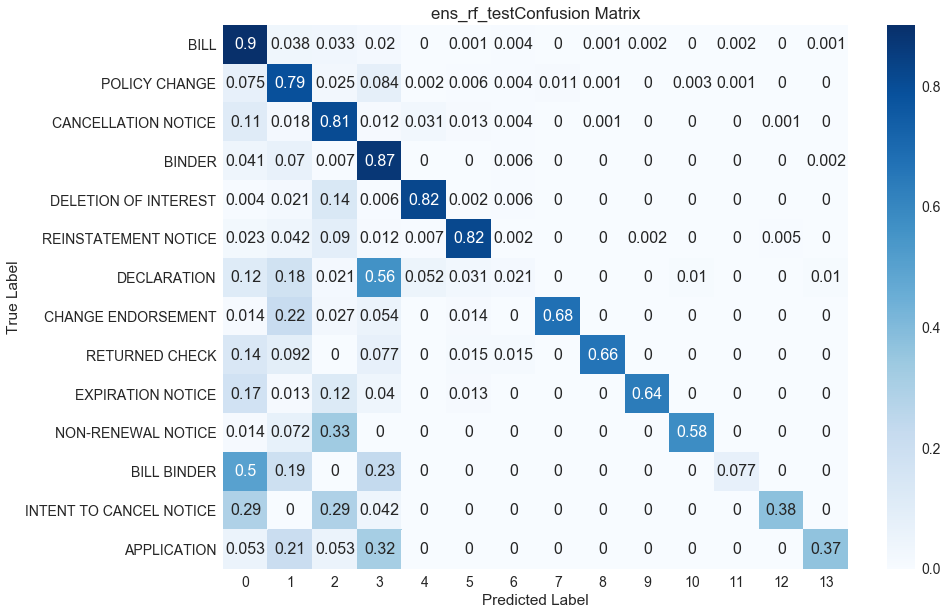

------Test Time----- 4.25326840796
------Accuray:  0.826424442609 ; F1 (micro):  0.826424442609 ; F1 (weighted):  0.820444558588


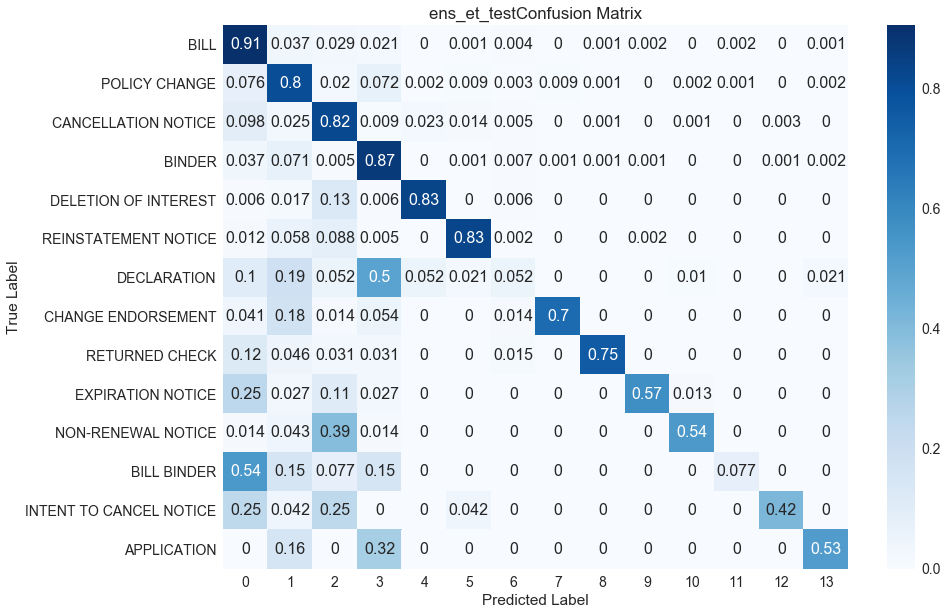

------Test Time----- 4.40358701409
------Accuray:  0.521882741536 ; F1 (micro):  0.521882741536 ; F1 (weighted):  0.467469117267


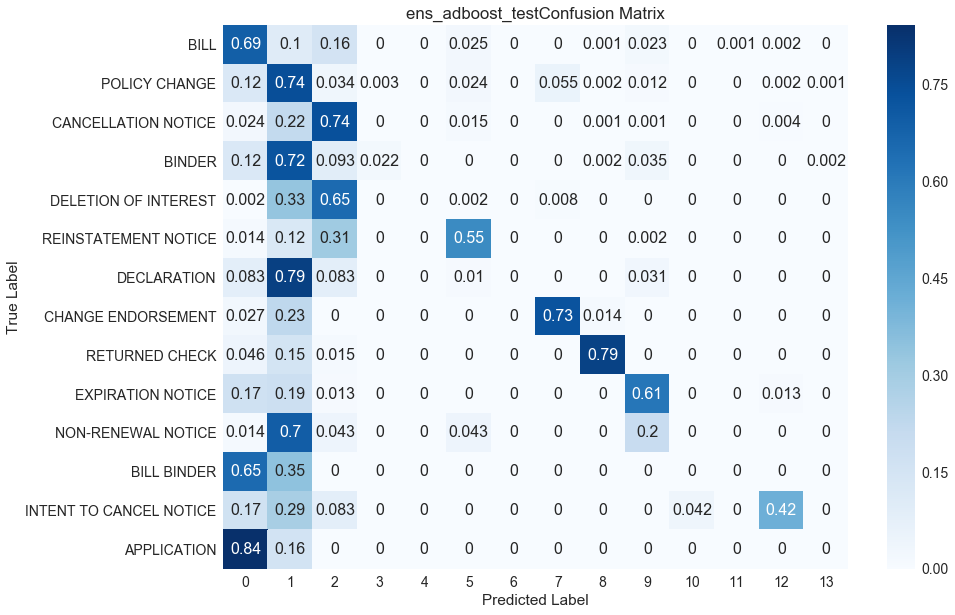

------Test Time----- 4.45403492863
------Accuray:  0.747976878613 ; F1 (micro):  0.747976878613 ; F1 (weighted):  0.740832560217


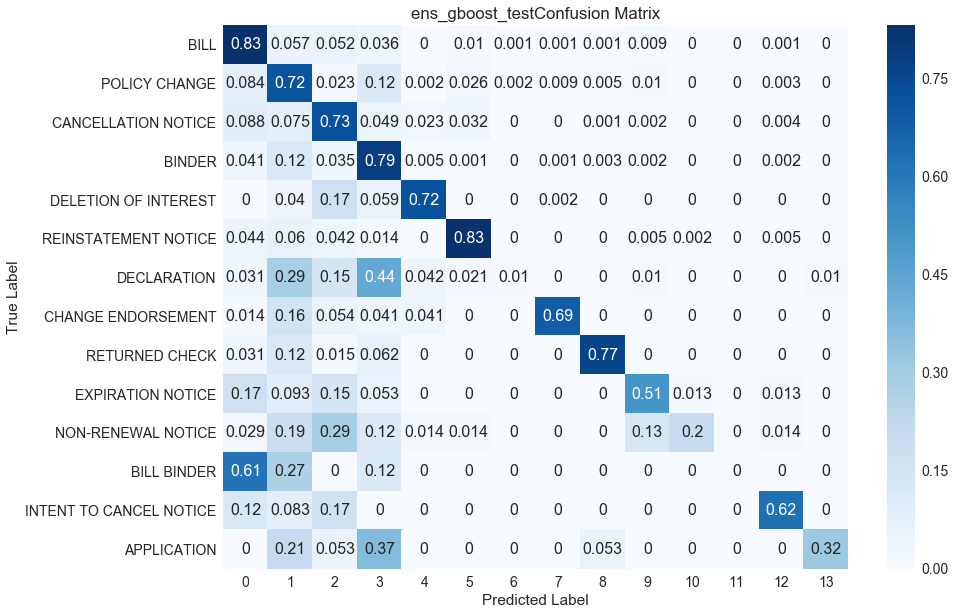

({0: {0: 0.81701073492981002, 1: 0.81036374769645958}, 1: {0: 0.82642444260941383, 1: 0.82044455858826271}, 2: {0: 0.52188274153592074, 1: 0.4674691172670179}, 3: {0: 0.74797687861271678, 1: 0.74083256021705357}}, {0: 0, 1: 0, 2: 0, 3: 0}, {0: 4.3154069858399, 1: 4.25326840795924, 2: 4.403587014090817, 3: 4.454034928630108})


In [8]:
# emsemble Classifiers
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.svm import SVC
names=['ens_rf_test','ens_et_test','ens_adboost_test','ens_gboost_test']
clf={}
clf[0]= RandomForestClassifier(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0)
clf[1]= ExtraTreesClassifier(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0)
clf[2]= AdaBoostClassifier(n_estimators=10)
clf[3]= GradientBoostingClassifier(n_estimators=10, learning_rate=1.0,max_depth=1, random_state=0)
results=trainModels(names,clf)
print results
filename='ens_F1results.pkl'
pickle.dump(results, open(filename,'wb')) # save model using Pickle

In [10]:
# print results
names=['ens_rf_test','ens_et_test','ens_adboost_test','ens_gboost_test']
filename='ens_F1results.pkl'
results=pickle.load(open(filename,'rb'))
for i in range(len(names)):
    print 'For %s method' %(names[i])
    print 'F1 score is %.2f (micro) and %.2f (weighted)' %(100*results[0][i][0],100*results[0][i][1])

For ens_rf_test method
F1 score is 81.70 (micro) and 81.04 (weighted)
For ens_et_test method
F1 score is 82.64 (micro) and 82.04 (weighted)
For ens_adboost_test method
F1 score is 52.19 (micro) and 46.75 (weighted)
For ens_gboost_test method
F1 score is 74.80 (micro) and 74.08 (weighted)


------Tranining Time----- 87.6089083424
------Test Time----- 4.14691551376
------Accuray:  0.78612716763 ; F1 (micro):  0.78612716763 ; F1 (weighted):  0.767957958497


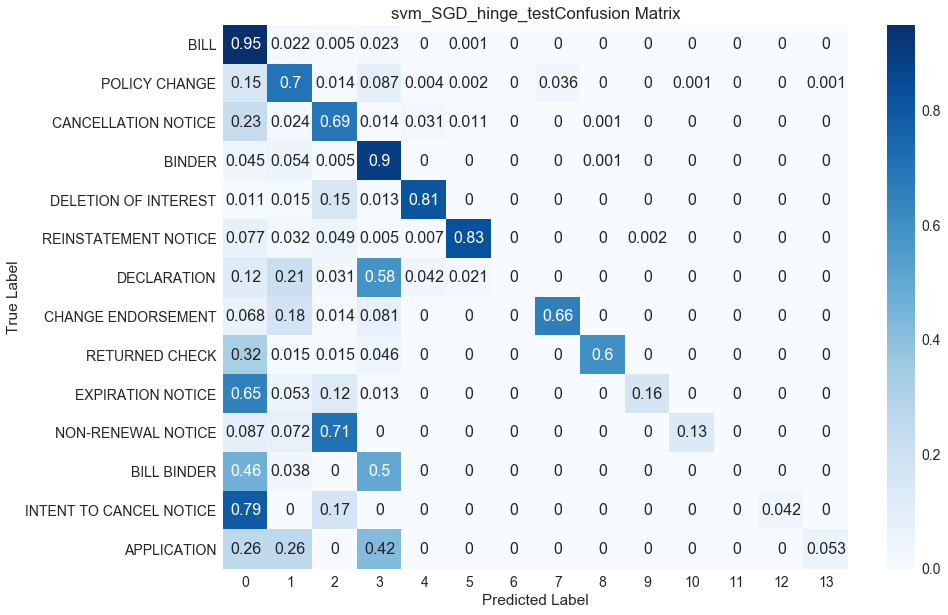

------Tranining Time----- 455.808567237
------Test Time----- 4.30880616994
------Accuray:  0.643600330306 ; F1 (micro):  0.643600330306 ; F1 (weighted):  0.592456118533


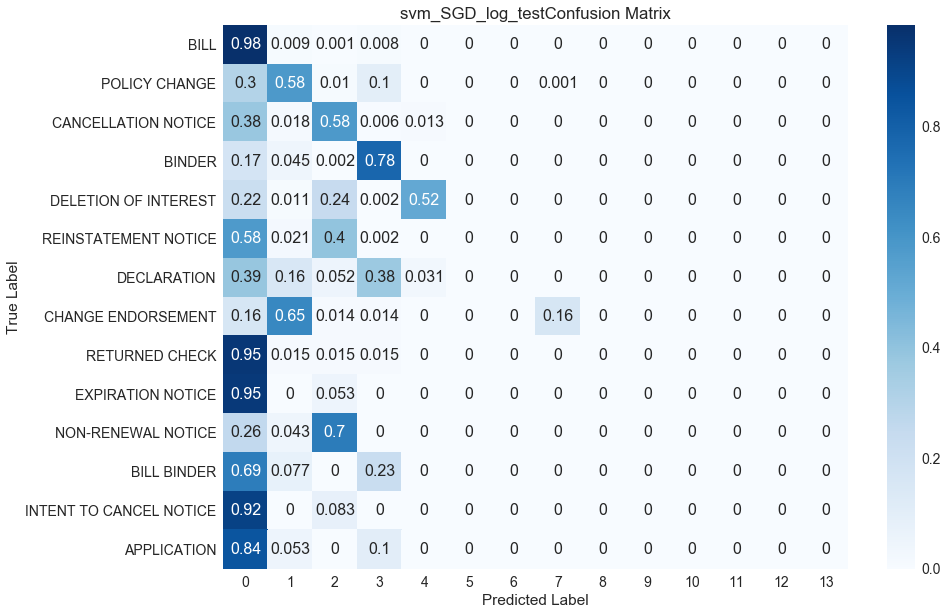

------Tranining Time----- 92.4701583729
------Test Time----- 4.44501690453
------Accuray:  0.817836498761 ; F1 (micro):  0.817836498761 ; F1 (weighted):  0.801844528123


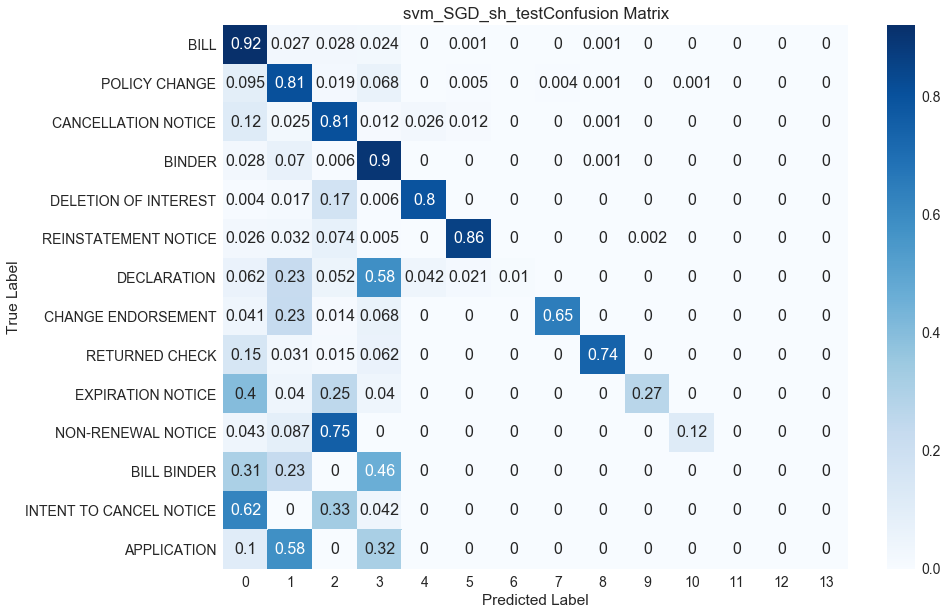

------Tranining Time----- 87.9598054514
------Test Time----- 4.20442362186
------Accuray:  0.859620148637 ; F1 (micro):  0.859620148637 ; F1 (weighted):  0.85843860555


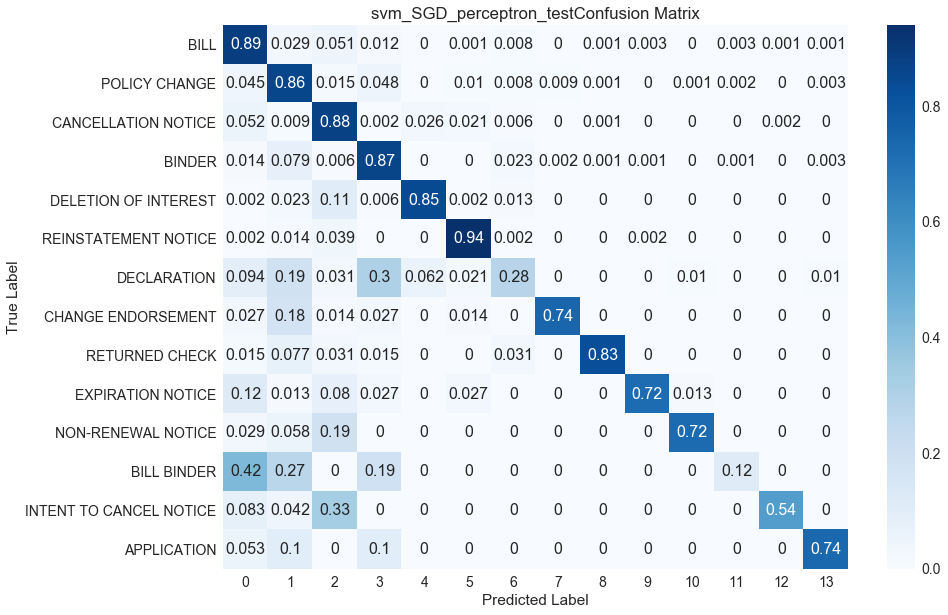

------Tranining Time----- 89.7239396341
------Test Time----- 4.30281434942
------Accuray:  0.818001651528 ; F1 (micro):  0.818001651528 ; F1 (weighted):  0.802003550081


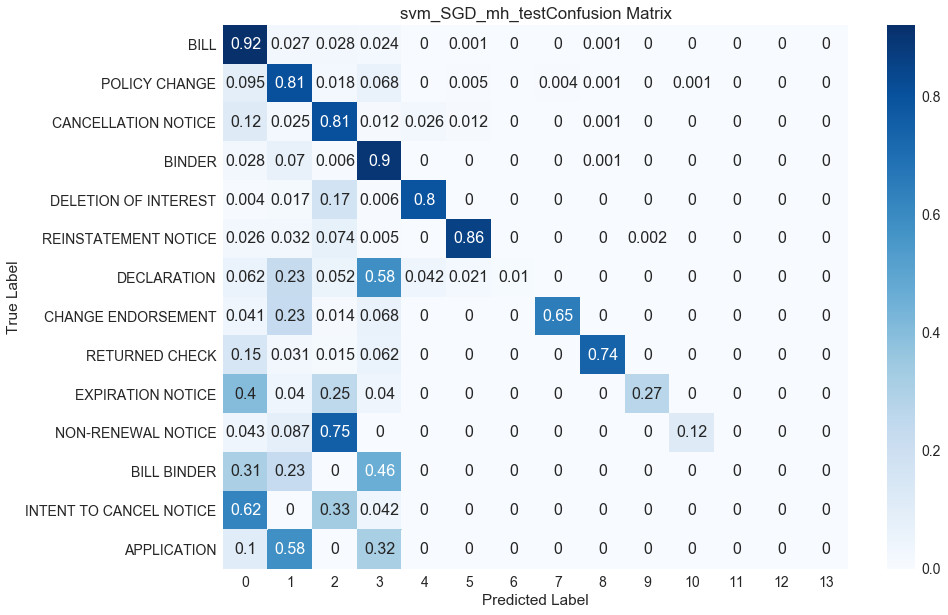

({0: {0: 0.78612716763005785, 1: 0.76795795849715509}, 1: {0: 0.64360033030553265, 1: 0.59245611853281788}, 2: {0: 0.81783649876135422, 1: 0.80184452812265528}, 3: {0: 0.8596201486374897, 1: 0.85843860555034901}, 4: {0: 0.81800165152766313, 1: 0.80200355008092272}}, {0: 87.60890834235761, 1: 455.8085672366724, 2: 92.47015837293293, 3: 87.95980545142811, 4: 89.72393963408103}, {0: 4.146915513760177, 1: 4.30880616993818, 2: 4.445016904530348, 3: 4.204423621857131, 4: 4.302814349422988})


In [11]:
## text SVM
name=['svm_SGD_hinge_test','svm_SGD_log_test','svm_SGD_sh_test','svm_SGD_perceptron_test','svm_SGD_mh_test']
clf=[SGDClassifier(loss='hinge',penalty='l2',alpha=1e-3,max_iter=1000,tol=1e-6,random_state=42),
     SGDClassifier(loss='log',penalty='l2',alpha=1e-3,max_iter=1000,tol=1e-6,random_state=42),
     SGDClassifier(loss='squared_hinge',penalty='l2',alpha=1e-3,max_iter=1000,tol=1e-6,random_state=42),
     SGDClassifier(loss='perceptron',penalty='l2',alpha=1e-3,max_iter=1000,tol=1e-6,random_state=42),
     SGDClassifier(loss='modified_huber',penalty='l2',alpha=1e-3,max_iter=1000,tol=1e-6,random_state=42)]
results=trainModels(name,clf)
print results
filename='svm_F1results.pkl'
pickle.dump(results, open(filename,'wb')) # save model using Pickle

In [12]:
# print results
for i in range(len(name)):
    print 'For %s method' %(name[i])
    print 'F1 score is %.2f (micro) and %.2f (weighted)' %(100*results[0][i][0],100*results[0][i][1])

For svm_SGD_hinge_test method
F1 score is 78.61 (micro) and 76.80 (weighted)
For svm_SGD_log_test method
F1 score is 64.36 (micro) and 59.25 (weighted)
For svm_SGD_sh_test method
F1 score is 81.78 (micro) and 80.18 (weighted)
For svm_SGD_perceptron_test method
F1 score is 85.96 (micro) and 85.84 (weighted)
For svm_SGD_mh_test method
F1 score is 81.80 (micro) and 80.20 (weighted)


## Model selection

According to the classification performance, Logistic regression is selected.

Although SVC and SGD_perceptron also showed good performance (86.4% and 85.9%), they failed to classify "Declaration" and "Bill Binder" this two classes.

Compare the results of the LR classifiers with different parameters:

In [ ]:
# select solver for logistic regression
methodNames=['LR_lbfgs','LR_cg','LR_sag','LR_liblinear']
clfs=[LogisticRegression(solver='lbfgs',multi_class='multinomial',class_weight='balanced',max_iter=1000,random_state = 42),
     LogisticRegression(solver='newton-cg',multi_class='multinomial',class_weight='balanced',max_iter=1000,random_state = 42),
     LogisticRegression(solver='sag',multi_class='multinomial',class_weight='balanced',max_iter=1000,random_state = 42),
     LogisticRegression(class_weight='balanced',max_iter=1000,random_state = 42)]
results=trainModels(methodNames,clfs)
fileName='LRF1Results.pkl'
pickle.dump(results, open(fileName,'wb'))

solver='lbfgs' with accuracy 84.9% is selected according to the trainning time and confusion matrix.

Next step is to select the parameter C which is inverse of regularization strength, smaller means stronger regularization

------Tranining Time----- 228.831140172
------Test Time----- 5.67089701806
------Accuray:  0.704541701073 ; F1 (micro):  0.704541701073 ; F1 (weighted):  0.729190862412


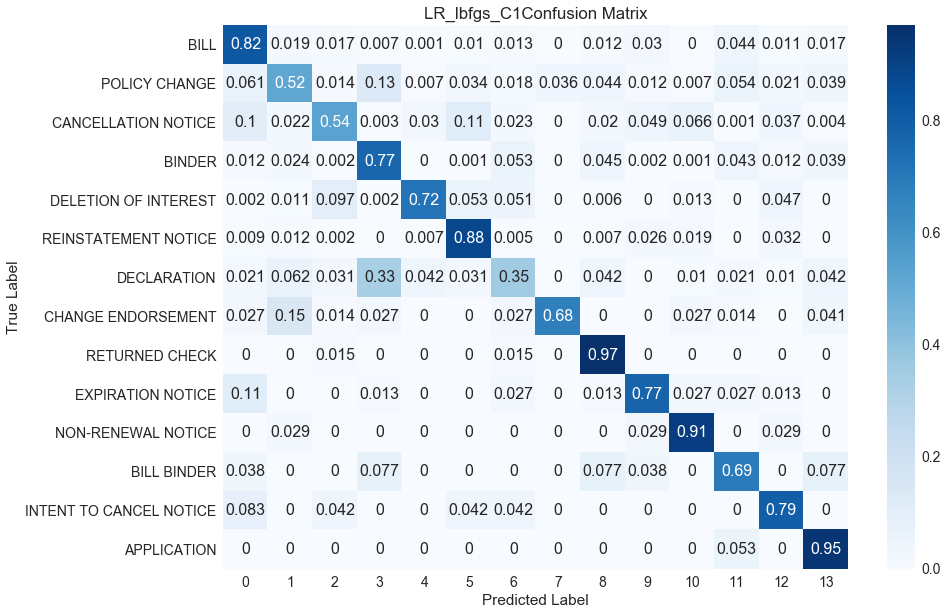

------Tranining Time----- 418.492521389
------Test Time----- 4.97552327807
------Accuray:  0.777539223782 ; F1 (micro):  0.777539223782 ; F1 (weighted):  0.795411833218


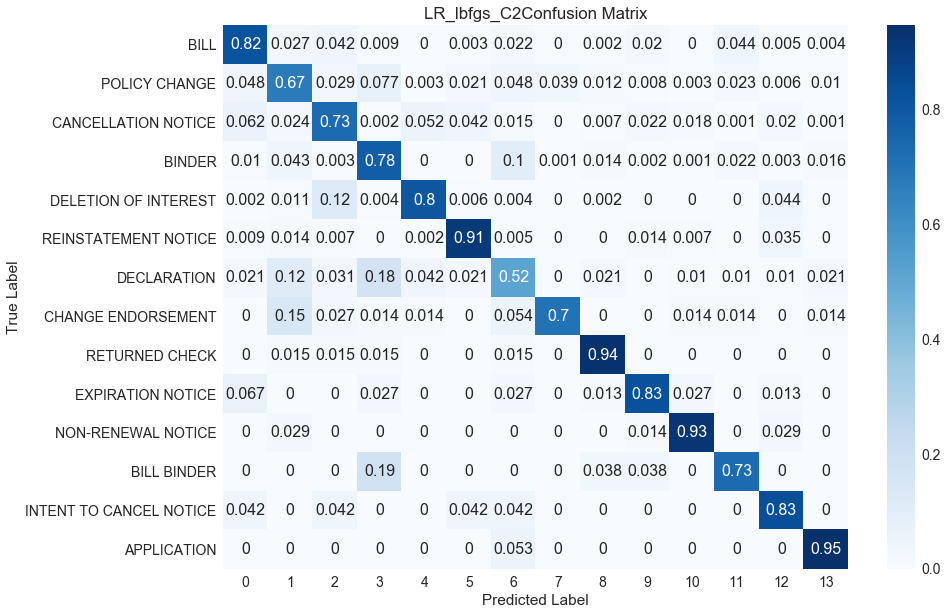

------Test Time----- 4.80870888997
------Accuray:  0.848885218827 ; F1 (micro):  0.848885218827 ; F1 (weighted):  0.855184033931


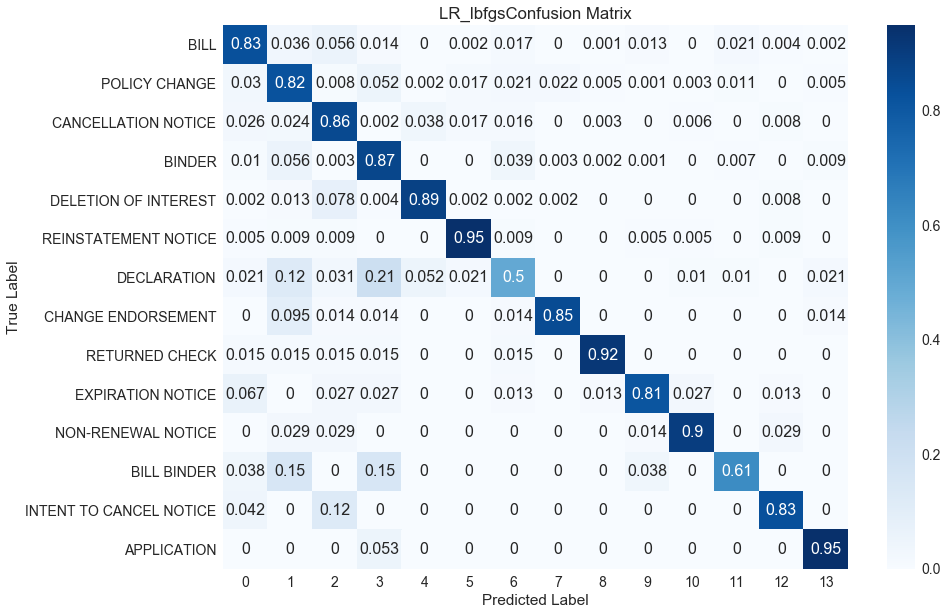

------Tranining Time----- 1330.71612253
------Test Time----- 5.89693442931
------Accuray:  0.867877786953 ; F1 (micro):  0.867877786953 ; F1 (weighted):  0.868711590253


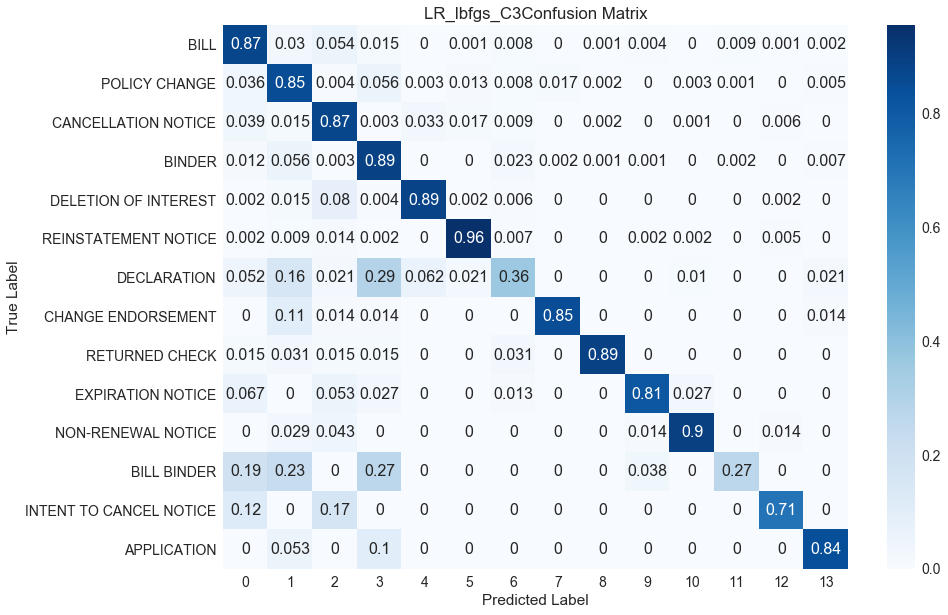

In [ ]:
# select C for logistic regression
# train and test classifiers
methodNames=['LR_lbfgs_C1','LR_lbfgs_C2','LR_lbfgs','LR_lbfgs_C3']
clfs=[LogisticRegression(C=0.01,solver='lbfgs',multi_class='multinomial',class_weight='balanced',max_iter=1000,random_state = 42),
     LogisticRegression(C=0.1,solver='lbfgs',multi_class='multinomial',class_weight='balanced',max_iter=1000,random_state = 42),
     LogisticRegression(solver='lbfgs',multi_class='multinomial',class_weight='balanced',max_iter=1000,random_state = 42),
      LogisticRegression(C=10,solver='lbfgs',multi_class='multinomial',class_weight='balanced',max_iter=1000,random_state = 42)]
results=trainModels(methodNames,clfs)
fileName='LR_C_F1Results.pkl'
pickle.dump(results, open(fileName,'wb'))

In [ ]:
# print results
for i in range(len(methodNames)):
    print 'For %s method' %(methodNames[i])
    print 'F1 score is %.2f (micro) and %.2f (weighted)' %(100*results[0][i][0],100*results[0][i][1])